# Pump it Up: Data Mining the Water Table

### Predict which water pumps are faulty?

Using data from Taarifa and the [Tanzanian Ministry of Water](https://www.maji.go.tz/), I will try to predict which pumps are functional, which need some repairs, and which don't work at all. The prediction will be based on a number of variables about what kind of pump is operating, when it was installed, how it is managed and other features (location, population, etc.). A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.


In [1]:
# Main librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

## Reading the data

In [3]:
# Reading data
data = pd.read_csv("training_set.csv")
data_label = pd.read_csv("training_set_labels.csv")
holdout = pd.read_csv("test_set_values.csv")
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
data_label.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
#merge training set and training set labels
data = data.merge(data_label, on="id")
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## 1. Data format analysis
### a. First features filtering

Base on the the columns descriptions located [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/),  and after eliminating redondant features and ones that are not related to the target, I decide to keep following columns


In [6]:
features = ["amount_tsh","gps_height","longitude", "latitude", "funder", "lga", "ward","date_recorded", "basin", "district_code", "population","permit", "construction_year","extraction_type_class", "management", "payment_type", "water_quality", "quantity", "source", "waterpoint_type","status_group"]
data = data[features]

# Data frame for exploration
df_exp = data.copy() 
df_exp.head()

,amount_tsh,gps_height,longitude,latitude,funder,lga,ward,date_recorded,basin,district_code,population,permit,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group
0,6000.0,1390,34.938093,-9.856322,Roman,Ludewa,Mundindi,2011-03-14,Lake Nyasa,5,109,False,1999,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional
1,0.0,1399,34.698766,-2.147466,Grumeti,Serengeti,Natta,2013-03-06,Lake Victoria,2,280,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,25.0,686,37.460664,-3.821329,Lottery Club,Simanjiro,Ngorika,2013-02-25,Pangani,4,250,True,2009,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,functional
3,0.0,263,38.486161,-11.155298,Unicef,Nanyumbu,Nanyumbu,2013-01-28,Ruvuma / Southern Coast,63,58,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional
4,0.0,0,31.130847,-1.825359,Action In A,Karagwe,Nyakasimbi,2011-07-13,Lake Victoria,1,0,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional


### b. Target values

In [7]:
df_exp["status_group"].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

1. The target values need to be converted into numerical values
2. Target values are not well balance, this will affect the choise of accuracy metric

### c. The shape of the data set

In [8]:
df_exp.shape

(59400, 21)

The data set has :
* 59400 rows
* 21 columns

### d. Data types

In [9]:
df_exp.dtypes.value_counts()

object     14
int64       4
float64     3
dtype: int64

We have :
* 7 numerical values
* 14 text (or other) values

### e. Missing values

In [10]:
df_exp.isna().sum()

amount_tsh                  0
gps_height                  0
longitude                   0
latitude                    0
funder                   3635
lga                         0
ward                        0
date_recorded               0
basin                       0
district_code               0
population                  0
permit                   3056
construction_year           0
extraction_type_class       0
management                  0
payment_type                0
water_quality               0
quantity                    0
source                      0
waterpoint_type             0
status_group                0
dtype: int64

It seems that only "permit" and "funder" columns has missing value. That needs more investigation maybe some numerical values have missing value represented by 0 ou negative numbers

## 2. Data content analysis
### a. Target analysis

See analysis above

### b. Numerical values

In [11]:
df_exp.select_dtypes(["int","float"]).columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'district_code',
       'population', 'construction_year'],
      dtype='object')

In [12]:
# amount_tsh
df_exp["amount_tsh"].value_counts(normalize=True).sort_values(ascending=False).head()

0.0       0.700993
500.0     0.052222
50.0      0.041616
1000.0    0.025051
20.0      0.024630
Name: amount_tsh, dtype: float64

amount_tsh: Stand for Total Static Head (difference in elevation of fluid’s source and destination surfaces). It cannot be 0. So It seems that 0 represente missing value and column has 70% of missing value. Let's skeep this columns

In [13]:
features.remove('amount_tsh')
features

['gps_height',
 'longitude',
 'latitude',
 'funder',
 'lga',
 'ward',
 'date_recorded',
 'basin',
 'district_code',
 'population',
 'permit',
 'construction_year',
 'extraction_type_class',
 'management',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type',
 'status_group']

In [14]:
df_exp["population"].value_counts(normalize=True).sort_values(ascending=False).head()

0      0.359949
1      0.118266
200    0.032660
150    0.031852
250    0.028300
Name: population, dtype: float64

<AxesSubplot:xlabel='population', ylabel='Density'>

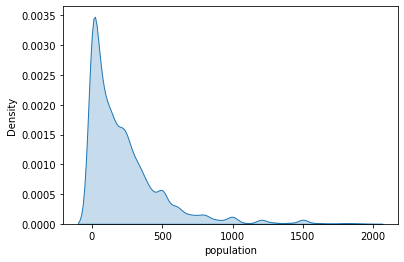

In [15]:
plt.figure()
col = "population"
sns.kdeplot(data=df_exp[(df_exp[col] > 0) & (df_exp[col] <2000)], x=col, fill=True)

Population : There is 36% of missing value, these values will be replace by the median (the distribution is skewed)

In [16]:
df_exp["construction_year"].value_counts(normalize=True).sort_values(ascending=False).head()

0       0.348636
2010    0.044529
2008    0.043990
2009    0.042643
2000    0.035202
Name: construction_year, dtype: float64

<AxesSubplot:xlabel='construction_year', ylabel='Density'>

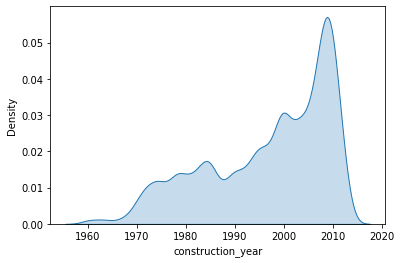

In [17]:
plt.figure()
col = "construction_year"
sns.kdeplot(data=df_exp[(df_exp[col] > 0)], x=col, fill=True)

Construction_year : There is 35% of missing value, these values will be replace by the median (the distribution is skewed). The value will used to calculate the age the pump

In [18]:
df_exp["district_code"].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

district_code : There is 23 missing values, these values will be replace by the most frequent value (categorical data )

### c. Qualitative values


In [19]:
for col in df_exp.select_dtypes('object'):
    #print(f'{col :-<50} {df_exp[col].unique()}')
    print(col)
    print(df_exp[col].unique())
    print("-" * 50)

funder
['Roman' 'Grumeti' 'Lottery Club' ... 'Dina' 'Brown' 'Samlo']
--------------------------------------------------
lga
['Ludewa' 'Serengeti' 'Simanjiro' 'Nanyumbu' 'Karagwe' 'Mkinga'
 'Shinyanga Rural' 'Kahama' 'Tabora Urban' 'Mkuranga' 'Namtumbo' 'Maswa'
 'Siha' 'Meatu' 'Sumbawanga Rural' 'Njombe' 'Ukerewe' 'Bariadi' 'Same'
 'Kigoma Rural' 'Moshi Rural' 'Lindi Rural' 'Rombo' 'Chamwino' 'Bagamoyo'
 'Mafia' 'Arusha Rural' 'Kyela' 'Kondoa' 'Kilolo' 'Kibondo' 'Makete'
 'Singida Rural' 'Masasi' 'Rungwe' 'Moshi Urban' 'Geita' 'Mbulu'
 'Bukoba Rural' 'Muheza' 'Lushoto' 'Meru' 'Iramba' 'Kilombero' 'Mbarali'
 'Kasulu' 'Bukoba Urban' 'Korogwe' 'Bukombe' 'Morogoro Rural' 'Kishapu'
 'Musoma Rural' 'Sengerema' 'Iringa Rural' 'Muleba' 'Dodoma Urban'
 'Ruangwa' 'Hanang' 'Misenyi' 'Missungwi' 'Songea Rural' 'Tanga' 'Tunduru'
 'Hai' 'Mwanga' 'Chato' 'Biharamulo' 'Ileje' 'Mpwapwa' 'Mvomero' 'Bunda'
 'Kiteto' 'Longido' 'Urambo' 'Mbozi' 'Sikonge' 'Ilala' 'Tarime' 'Temeke'
 'Mbeya Rural' 'Magu' 'Many

date_recorded : This column will be used to calculate the age of the pump.
For the first model, we won't take the features engeneering further

## 3. Data pre-processing

### a. building the data frame

In [20]:
#features.remove("date_recorded")
#features.remove("construction_year")
df_pp = data.copy()
df_pp = df_pp[features]
df_pp.head()

,gps_height,longitude,latitude,funder,lga,ward,date_recorded,basin,district_code,population,permit,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group
0,1390,34.938093,-9.856322,Roman,Ludewa,Mundindi,2011-03-14,Lake Nyasa,5,109,False,1999,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional
1,1399,34.698766,-2.147466,Grumeti,Serengeti,Natta,2013-03-06,Lake Victoria,2,280,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,686,37.460664,-3.821329,Lottery Club,Simanjiro,Ngorika,2013-02-25,Pangani,4,250,True,2009,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,functional
3,263,38.486161,-11.155298,Unicef,Nanyumbu,Nanyumbu,2013-01-28,Ruvuma / Southern Coast,63,58,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional
4,0,31.130847,-1.825359,Action In A,Karagwe,Nyakasimbi,2011-07-13,Lake Victoria,1,0,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional


### b. Train-test - data cleaning - data encoding

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_set, test_set = train_test_split(df_pp, test_size=.2, random_state=14)

In [23]:
train_set["status_group"].value_counts(normalize=True)

functional                 0.542088
non functional             0.384196
functional needs repair    0.073716
Name: status_group, dtype: float64

In [24]:
test_set["status_group"].value_counts()

functional                 6499
non functional             4567
functional needs repair     814
Name: status_group, dtype: int64

In [25]:
# Custom transformers to use in the processing pipeline

def recorded_year_extractor(X):
    """Extract recorded year

    Usage
    ------

    df = recorded_year_extractor(df)
    """

    df = pd.DataFrame(X)
    #df["recorded_year"] = pd.to_datetime(df["date_recorded"]).dt.year
    df["date_recorded"] =  df["date_recorded"].apply(lambda x : pd.to_datetime(x).year)

    return pd.DataFrame(df)
def pump_age_calculator(X):
    """calculate the age the pump 

    Usage
    ------

    train = pump_age_calculator(train)
    """

    df = pd.DataFrame(X)

    return pd.DataFrame(df.iloc[:,0] - df.iloc[:,1])

def numeric_missing_indicator(X):
    """Replace all the missing value (negaive or null) by -1

    Usage
    ------

    train = population_missing_indicator(train)
    """ 
    X = np.where(X <= 0, -1, X)
    return X

def permit_missing_indicator(X):
    """Replace all the missing value (negaive or null) by "Unknown"

    Usage
    ------

    train = permit_missing_indicator(train)
    """ 

    df = pd.DataFrame(X)
    df["permit"] = df["permit"].apply(lambda x : 1 if x == True else ( 0 if x == False else 2))
    return df


In [26]:
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder,LabelBinarizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

In [27]:
cat_features = df_pp.select_dtypes('object').columns.tolist()
cat_features.remove("status_group")
cat_features.remove("date_recorded")
cat_features.append("district_code") # It is a categorical data represented by numbers
cat_features

['funder',
 'lga',
 'ward',
 'basin',
 'permit',
 'extraction_type_class',
 'management',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type',
 'district_code']

In [28]:
# gps_height pipeline
pipeline_gps_height = make_pipeline(FunctionTransformer(numeric_missing_indicator),
                                    SimpleImputer(missing_values=-1, strategy='median')
                                    )
transformer_gps_height = make_column_transformer((pipeline_gps_height,["gps_height"]))

In [29]:
# longitude & latitude pipeline
transformer_longitude_latitude = make_column_transformer(("passthrough",["longitude","latitude"]))

In [30]:
# pump age pipeline
pipeline_pump_age_calculator = make_pipeline(FunctionTransformer(recorded_year_extractor),
                                             FunctionTransformer(numeric_missing_indicator),
                                             SimpleImputer(missing_values=-1, strategy='median'),
                                             FunctionTransformer(pump_age_calculator)
                                             )
transformer_pump_age_calculator = make_column_transformer((pipeline_pump_age_calculator,["date_recorded","construction_year"]))

In [31]:
# population pipeline
pipeline_population = make_pipeline(FunctionTransformer(numeric_missing_indicator),
                                    SimpleImputer(missing_values=-1, strategy='median')
                                    )
transformer_population = make_column_transformer((pipeline_population,["population"]))

In [32]:
# permit missing indcator
pipeline_permit_missing_indicator = make_pipeline(FunctionTransformer(permit_missing_indicator),
                                                  OneHotEncoder(handle_unknown='ignore', sparse=False))
transformer_permit_missing_indicator = make_column_transformer((pipeline_permit_missing_indicator, ["permit"]))

In [33]:
# Categorical feature pipeline
# categories=cat_features, 
pipeline_one_hot_encoder = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse=False))
transformer_one_hot_encoder = make_column_transformer((pipeline_one_hot_encoder, cat_features))

In [34]:
features_union = make_union(transformer_gps_height,
                            transformer_longitude_latitude,
                            transformer_pump_age_calculator,
                            transformer_population,
                            transformer_permit_missing_indicator,
                            transformer_one_hot_encoder
)
#union_model.fit_transform(train_set.drop("status_group", axis=1))

In [35]:
# Resample
from sklearn.utils import resample
def down_sample(df):
    df_f = df[df["status_group"] == "functional"]
    df_nf = df[df["status_group"] == "non functional"]
    df_r = df[df["status_group"] == "functional needs repair"]
    size = df_r.shape[0]
    df_f_down = resample(df_f, replace=False, n_samples=size, random_state=14)
    df_nf_down = resample(df_nf, replace=False, n_samples=size, random_state=14)

    df_downsampled = pd.concat([df_f_down, df_nf_down, df_r])

    return df_downsampled


I've tried the downsample technique but it doesn't work well for this project, and the final classifier I choosed doesn't need downsampling

In [36]:
def get_train_test():
    #df = down_sample(train_set)
    df = train_set
    X_train = df.drop("status_group", axis=1)
    y_train = df["status_group"]
    X_test = test_set.drop("status_group", axis=1)
    y_test = test_set["status_group"]
    
    return X_train, y_train, X_test, y_test

In [37]:
X_train, y_train, X_test, y_test = get_train_test()
print(X_train.shape)
print(X_test.shape)

(47520, 19)
(11880, 19)


In [38]:
# The target encoder
y_pre_processor = LabelEncoder()
y_train = y_pre_processor.fit_transform(y_train)
y_test = y_pre_processor.transform(y_test)

## 4. Modelling

After the data processing pipeling, it's time to start modelling

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier

In [40]:
# a pipeline for preprocessing
#X_pre_processor = make_pipeline(features_union, MinMaxScaler(), SelectKBest(f_classif, k=700))
X_pre_processor = make_pipeline(features_union, MinMaxScaler())


Shape = (47520, 4019)

In [41]:
# models
random_forest = make_pipeline(X_pre_processor, RandomForestClassifier(min_samples_split=15, min_samples_leaf=1, criterion="gini", class_weight=None, random_state=14))
#svm = make_pipeline(X_pre_processor, PolynomialFeatures(degree=3), LinearSVC(C=10, loss="hinge", random_state=14, max_iter=1000))
svm = make_pipeline(X_pre_processor, SVC(kernel="poly", degree=10, coef0=1, C=15, class_weight= "balanced", random_state=14))
knn = make_pipeline(X_pre_processor, KNeighborsClassifier(n_neighbors=20))
sgc = make_pipeline(X_pre_processor, SGDClassifier(random_state=14))


In [42]:
models_dict = { #"svm": svm,
                "RandomForestClassifier" : random_forest
                #"SGDClassifier": sgc, 
               # "KNeighborsClassifier" : knn
                }

## 5. Evaluation process

In [43]:
def evaluate_model(model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    #N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, train_sizes=np.linspace(0.1,1,10))

    #plt.figure(figsize=(12,8))
    #plt.plot(N, train_score.mean(axis=1), label="train score")
    #plt.plot(N, val_score.mean(axis=1), label="validation score")
    #plt.legend()

In [44]:
# The evaluation process
for name, model in models_dict.items():
    print(name)
    #evaluate_model(model)
    print("-" * 100)

RandomForestClassifier
----------------------------------------------------------------------------------------------------


```
RandomForestClassifier *** all *** features
[[5919   84  496]
 [ 437  245  132]
 [ 949   43 3575]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      6499
           1       0.66      0.30      0.41       814
           2       0.85      0.78      0.82      4567

    accuracy                           0.82     11880
   macro avg       0.77      0.66      0.70     11880
weighted avg       0.82      0.82      0.81     11880

```

## 5. Optimization
Let's try to optimize the choosen model (randomforest)

In [45]:
# Best features
k_best_features = list(range(100,1510,100)) + list(range(2019,3800,500))
k_best_features.append("all")

# Number of trees in random forest
n_estimators = list(range(100,301, 50))

#criterion
criterion = ["gini", "entropy"]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', "log2"]

# Maximum number of levels in tree
max_depth = list(range(10, 1001, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5, 7]

# Method of selecting samples for training each tree
bootstrap = [True, False]

class_weight = ["balanced", "balanced_subsample", None]

# Create the random grid
param_distributions = { #'pipeline__selectkbest__k': k_best_features,
                        'randomforestclassifier__n_estimators': n_estimators,
                       # 'randomforestclassifier__max_features': max_features,
                       # 'randomforestclassifier__max_depth': max_depth,
                        'randomforestclassifier__min_samples_split': min_samples_split,
                        'randomforestclassifier__min_samples_leaf': min_samples_leaf,
                        'randomforestclassifier__criterion':criterion,
                        'randomforestclassifier__class_weight':class_weight
                       # 'randomforestclassifier__bootstrap': bootstrap
}

#print(param_distributions)

In [46]:
#gridSCV = RandomizedSearchCV(random_forest, param_distributions, cv=4, n_iter=30)
#gridSCV.fit(X_train, y_train)
#print(gridSCV.best_params_)
#y_pred = gridSCV.predict(X_test)
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

```
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 15, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__class_weight': None, 'pipeline__selectkbest__k': 1300}
[[5919   79  501]
 [ 441  243  130]
 [ 990   42 3535]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.85      6499
           1       0.67      0.30      0.41       814
           2       0.85      0.77      0.81      4567

    accuracy                           0.82     11880
   macro avg       0.77      0.66      0.69     11880
weighted avg       0.81      0.82      0.81     11880

```

In [47]:
#param_distributions = { 'pipeline__selectkbest__k': list(range(3500,4019,100))}
#gridSCV = GridSearchCV(random_forest, param_distributions, cv=5)
#gridSCV.fit(X_train, y_train)
#print(gridSCV.best_params_)
#y_pred = gridSCV.predict(X_test)
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

# 6. Final model

In [48]:
    X_pre_processor = make_pipeline(features_union, MinMaxScaler())
    rdf = RandomForestClassifier(n_estimators=100, min_samples_split=15, min_samples_leaf=1, criterion="gini", class_weight=None, random_state=14)
    final_model = make_pipeline(X_pre_processor, rdf)

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)

    print("confusion_matrix")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)
    print("classification_report")
    print(classification_report(y_test, y_pred))

    #N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, train_sizes=np.linspace(0.1,1,10))
    #plt.figure(figsize=(12,8))
    #plt.plot(N, train_score.mean(axis=1), label="train score")
    #plt.plot(N, val_score.mean(axis=1), label="validation score")
    #plt.legend()

confusion_matrix
[[5919   84  496]
 [ 437  245  132]
 [ 949   43 3575]]
--------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      6499
           1       0.66      0.30      0.41       814
           2       0.85      0.78      0.82      4567

    accuracy                           0.82     11880
   macro avg       0.77      0.66      0.70     11880
weighted avg       0.82      0.82      0.81     11880



# 7. Submission

In [49]:
def save_submission_file(estimator, features, output_filename):  
    predictions = estimator.predict(holdout[features])
    submission = pd.DataFrame(holdout["id"])
    submission["status_group"] = pd.Series(y_pre_processor.inverse_transform(predictions))
    submission.to_csv(output_filename, index=False)
    
#save_submission_file(final_model, X_train.columns, "pump_submission.csv")

# 8. Conclusion

The metric used in this challenge is the classification rate and I got 0.8136 (81.36% of accuracy)